<a href="https://colab.research.google.com/github/Cloud2602/gesture_recognition/blob/main/gesture_recognition_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.9

Found existing installation: mediapipe 0.10.9
Uninstalling mediapipe-0.10.9:
  Successfully uninstalled mediapipe-0.10.9
  Using cached mediapipe-0.10.9-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
Using cached mediapipe-0.10.9-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)


In [2]:
!pip install tensorflow

In [13]:
!pip install pyrealsense2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 27.8 MB/s eta 0:00:00


In [4]:
!unzip -q "/content/dataset-hands.zip" -d "/content/dataset_hands"

In [3]:
!git clone https://github.com/Cloud2602/gesture_recognition.git

Cloning into 'gesture_recognition'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 460 (delta 0), reused 0 (delta 0), pack-reused 457 (from 1)
Receiving objects: 100% (460/460), 50.70 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (208/208), done.
Updating files: 100% (345/345), done.


In [ ]:
%cd /content/gesture_recognition
!git pull

# With real z

### Landmark Extraction

In [7]:
import os
import cv2
import mediapipe as mp
import numpy as np
import csv

# --- Parametri ---
BASE_DIR = "/content/dataset_hands/dataset-hands"
OUTPUT_DIR = "/content/dataset_NOT_augmented"
radius = 40  # per la media attorno al punto depth

# Crea la cartella di output se non esiste
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Funzione per profondità valida ---
def get_valid_depth_avg(depth_map, x, y, radius=40):
    h, w = depth_map.shape
    values = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)
    return np.mean(values) if values else 0.0

# --- Setup MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

# Header CSV
header = [f'{dim}{i}_R' for i in range(21) for dim in ['x', 'y', 'z']]
header += [f'{dim}{i}_L' for i in range(21) for dim in ['x', 'y', 'z']]

# --- Elabora tutte le cartelle ---
for folder_name in sorted(os.listdir(BASE_DIR)):
    folder_path = os.path.join(BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    output_csv = os.path.join(OUTPUT_DIR, f"{folder_name}.csv")
    output_npy = os.path.join(OUTPUT_DIR, f"{folder_name}.npy")
    all_landmarks = []
    count_right = count_left = count_total = 0

    with open(output_csv, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(header)

        for filename in sorted(os.listdir(folder_path)):
            if not filename.endswith("_Color.png"):
                continue

            base_name = filename.replace("_Color.png", "")
            depth_raw_path = os.path.join(folder_path, f"{base_name}_Depth.raw")
            image_path = os.path.join(folder_path, filename)
            depth_png_path = os.path.join(folder_path, f"{base_name}_Depth.png")

            # Carica immagine
            image_bgr = cv2.imread(image_path)
            depth_png = cv2.imread(depth_png_path)
            if image_bgr is None or depth_png is None or not os.path.exists(depth_raw_path):
                print(f"❌ Errore file in: {filename} nella cartella {folder_name}")
                continue

            height, width, _ = depth_png.shape
            depth_raw = np.fromfile(depth_raw_path, dtype=np.uint16)
            if depth_raw.size != height * width:
                print(f"⚠️ Dimensione depth non corretta per {filename} in {folder_name}")
                continue

            depth_map = depth_raw.reshape((height, width)).astype(np.float32) / 10000.0  # in metri

            for flip in [False, True]:
                img_proc = cv2.flip(image_bgr, 1) if flip else image_bgr
                img_rgb = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
                results = hands.process(img_rgb)

                right_hand = [0.0] * (21 * 3)
                left_hand = [0.0] * (21 * 3)

                if results.multi_hand_landmarks and results.multi_handedness:
                    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                        label = handedness.classification[0].label
                        label = "Left" if label == "Right" else "Right"

                        landmarks = []
                        for lm in hand_landmarks.landmark:
                            x = lm.x
                            y = lm.y
                            px = min(int(x * width), width - 1)
                            py = min(int(y * height), height - 1)
                            z = get_valid_depth_avg(depth_map, px, py, radius=radius)
                            landmarks.extend([x, y, z])

                        if label == "Right":
                            right_hand = landmarks
                            count_right += 1
                        else:
                            left_hand = landmarks
                            count_left += 1

                combined = right_hand + left_hand
                all_landmarks.append(combined)
                csv_writer.writerow(combined)
                count_total += 1

    # Salva file .npy
    np.save(output_npy, np.array(all_landmarks))

    # Riepilogo
    print(f"\n📁 Cartella: {folder_name}")
    print(f"✅ Landmark salvati in {output_csv} e {output_npy}")
    print(f"📸 Immagini analizzate (incl. flip): {count_total}")
    print(f"🖐️ Mani rilevate: Destra {count_right} | Sinistra {count_left}")
    print(f"📊 Campioni totali: {len(all_landmarks)}")



📁 Cartella: 0
✅ Landmark salvati in /content/dataset_NOT_augmented/0.csv e /content/dataset_NOT_augmented/0.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 142 | Sinistra 138
📊 Campioni totali: 140

📁 Cartella: 1
✅ Landmark salvati in /content/dataset_NOT_augmented/1.csv e /content/dataset_NOT_augmented/1.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 67 | Sinistra 67
📊 Campioni totali: 140

📁 Cartella: 2
✅ Landmark salvati in /content/dataset_NOT_augmented/2.csv e /content/dataset_NOT_augmented/2.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 64 | Sinistra 67
📊 Campioni totali: 140

📁 Cartella: 3
✅ Landmark salvati in /content/dataset_NOT_augmented/3.csv e /content/dataset_NOT_augmented/3.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 69 | Sinistra 70
📊 Campioni totali: 140


### Add Augumentation

In [8]:
import os
import numpy as np

# === Funzioni di Data Augmentation ===
def zoom_landmarks(landmarks, scale=0.8):
    center = landmarks[0]
    return (landmarks - center) * scale + center

def rotate_landmarks(landmarks, angle_deg=15):
    angle_rad = np.radians(angle_deg)
    center = landmarks[0]
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    rotated = np.dot(landmarks[:, :2] - center[:2], rotation_matrix) + center[:2]
    landmarks[:, :2] = rotated
    return landmarks

def translate_landmarks(landmarks, offset=(0.05, -0.03, 0.0)):
    return landmarks + np.array(offset)

# === Percorsi da modificare ===
input_base_dir = "/content/dataset_NOT_augmented"
output_base_dir = "/content/data_augumented"

os.makedirs(output_base_dir, exist_ok=True)

# === Elaborazione dei file ===
for file_name in sorted(os.listdir(input_base_dir)):
            augmented = [] # Initialize augmented here

            if file_name.endswith('.npy'):
                print(f"✔️ File: {file_name}")
                file_path = os.path.join(input_base_dir, file_name)
                landmarks = np.load(file_path)

                for i, landmark in enumerate(landmarks):
                  landmark = landmark.reshape((42, 3))  # (21 dx + 21 sx)
                  right = landmark[:21]
                  left = landmark[21:]


                  # Salva sempre l'originale
                  augmented.append(landmark.copy())

                  # === AUGMENTATION PARZIALE ===
                  # Zoom, rotazione, traslazione applicate solo alle mani presenti

                  # Zoom
                  zoomed = landmark.copy()
                  if not np.allclose(right, 0.0):
                      zoomed[:21] = zoom_landmarks(right.copy(), scale=0.8)
                  if not np.allclose(left, 0.0):
                      zoomed[21:] = zoom_landmarks(left.copy(), scale=0.8)
                  augmented.append(zoomed)

                  # Rotazione +15°
                  rotated_p15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_p15[:21] = rotate_landmarks(right.copy(), angle_deg=15)
                  if not np.allclose(left, 0.0):
                      rotated_p15[21:] = rotate_landmarks(left.copy(), angle_deg=15)
                  augmented.append(rotated_p15)

                  # Rotazione -15°
                  rotated_m15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_m15[:21] = rotate_landmarks(right.copy(), angle_deg=-15)
                  if not np.allclose(left, 0.0):
                      rotated_m15[21:] = rotate_landmarks(left.copy(), angle_deg=-15)
                  augmented.append(rotated_m15)

                  # Traslazione +
                  translated_p = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_p[:21] = translate_landmarks(right.copy(), offset=(0.05, -0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_p[21:] = translate_landmarks(left.copy(), offset=(0.05, -0.03, 0.0))
                  augmented.append(translated_p)

                  # Traslazione -
                  translated_m = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_m[:21] = translate_landmarks(right.copy(), offset=(-0.05, 0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_m[21:] = translate_landmarks(left.copy(), offset=(-0.05, 0.03, 0.0))
                  augmented.append(translated_m)

            else:
                print(f"⚠️ File non valido: {file_name}")

            print("augumented lenght: ", len(augmented))
            new_name = f"{os.path.splitext(file_name)[0]}.npy"
            save_path = os.path.join(output_base_dir, new_name)
            np.save(save_path, augmented)
            print(f"✔️ File salvato: {save_path}")

⚠️ File non valido: 0.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/0.npy
✔️ File: 0.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/0.npy
⚠️ File non valido: 1.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/1.npy
✔️ File: 1.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/1.npy
⚠️ File non valido: 2.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/2.npy
✔️ File: 2.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/2.npy
⚠️ File non valido: 3.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/3.npy
✔️ File: 3.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/3.npy


Discard all zeros samples

In [9]:
import os
import numpy as np

# === Parametri ===
TARGET_DIR = "/content/data_augumented"

# === Scorri ogni file .npy nella cartella ===
for filename in sorted(os.listdir(TARGET_DIR)):
    if not filename.endswith(".npy"):
        continue

    file_path = os.path.join(TARGET_DIR, filename)
    print(f"\n📂 File: {filename}")

    # Carica il file
    data = np.load(file_path)
    print(f"🔢 Sample totali iniziali: {len(data)}")

    # Filtro dei sample
    filtered = []
    for i, sample in enumerate(data):
        sample = sample.reshape((42, 3))
        right = sample[:21]
        left = sample[21:]

        right_zero = np.allclose(right, 0.0)
        left_zero = np.allclose(left, 0.0)

        if right_zero and left_zero:
            print(f"🗑️  Sample {i} rimosso: TUTTO ZERO")
            continue

        filtered.append(sample)

    # Salva sovrascrivendo il file originale
    filtered = np.array(filtered)
    np.save(file_path, filtered)
    print(f"✅ Nuovo file salvato: {len(filtered)} sample scritti in '{filename}'")



📂 File: 0.npy
🔢 Sample totali iniziali: 840
✅ Nuovo file salvato: 840 sample scritti in '0.npy'

📂 File: 1.npy
🔢 Sample totali iniziali: 840
🗑️  Sample 156 rimosso: TUTTO ZERO
🗑️  Sample 157 rimosso: TUTTO ZERO
🗑️  Sample 158 rimosso: TUTTO ZERO
🗑️  Sample 159 rimosso: TUTTO ZERO
🗑️  Sample 160 rimosso: TUTTO ZERO
🗑️  Sample 161 rimosso: TUTTO ZERO
🗑️  Sample 162 rimosso: TUTTO ZERO
🗑️  Sample 163 rimosso: TUTTO ZERO
🗑️  Sample 164 rimosso: TUTTO ZERO
🗑️  Sample 165 rimosso: TUTTO ZERO
🗑️  Sample 166 rimosso: TUTTO ZERO
🗑️  Sample 167 rimosso: TUTTO ZERO
🗑️  Sample 180 rimosso: TUTTO ZERO
🗑️  Sample 181 rimosso: TUTTO ZERO
🗑️  Sample 182 rimosso: TUTTO ZERO
🗑️  Sample 183 rimosso: TUTTO ZERO
🗑️  Sample 184 rimosso: TUTTO ZERO
🗑️  Sample 185 rimosso: TUTTO ZERO
🗑️  Sample 186 rimosso: TUTTO ZERO
🗑️  Sample 187 rimosso: TUTTO ZERO
🗑️  Sample 188 rimosso: TUTTO ZERO
🗑️  Sample 189 rimosso: TUTTO ZERO
🗑️  Sample 190 rimosso: TUTTO ZERO
🗑️  Sample 191 rimosso: TUTTO ZERO
🗑️  Sample 456 rim

### Training

In [11]:
!python /content/gesture_recognition/train.py

2025-06-30 09:18:14.508986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751275094.573970    5965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751275094.593425    5965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-30 09:18:20.904064: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

### Test Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
✅ Predizione: Classe 3 (softmax: [1.0603949e-06 5.1406170e-07 3.0254082e-06 9.9999535e-01])


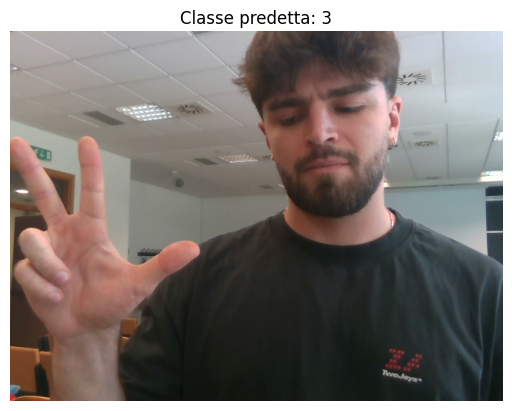

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

# === CONFIG ===
model_path = "best_model.h5"
image_path = "/content/dataset_hands/dataset-hands/3/33_Color.png"
depth_path = "/content/dataset_hands/dataset-hands/3/33_Depth.raw"

depth_shape = (480, 640)  # corretto: (altezza, larghezza)
if depth_path.split('/')[4] == '3':
  depth_shape = (320,240)
depth_dtype = np.uint16
depth_scale = 0.0001  # 1 unità = 0.1 mm
radius = 40  # come nel training

# === Funzione coerente con il training ===
def get_valid_depth_avg(depth_map, x, y, radius=40):
    h, w = depth_map.shape
    values = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)
    return np.mean(values) if values else 0.0

# === 1. Carica immagine e depth ===
color_image = cv2.imread(image_path)
color_image_shape = color_image.shape
depth_image = np.fromfile(depth_path, dtype=depth_dtype).reshape(depth_shape)

h, w, _ = color_image.shape
mean = np.load("/content/scaler_mean.npy")
std = np.load("/content/scaler_scale.npy")
# === 2. Mediapipe ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
rgb_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
result = hands.process(rgb_image)

if not result.multi_hand_landmarks:
    print("❌ Nessuna mano rilevata.")
    exit()

def get_landmark_xyz(landmarks, depth_img, h, w):
    xyz = []
    for lm in landmarks.landmark:
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        if 0 <= x_px < w and 0 <= y_px < h:
            z = get_valid_depth_avg(depth_img, x_px, y_px, radius=radius) * depth_scale
        else:
            z = 0.0
        xyz.extend([lm.x, lm.y, z])
    return np.array(xyz)

# === 3. Estrai landmark (max 2 mani) ===
first_hand_xyz = get_landmark_xyz(result.multi_hand_landmarks[0], depth_image, h, w)

if len(result.multi_hand_landmarks) > 1:
    second_hand_xyz = get_landmark_xyz(result.multi_hand_landmarks[1], depth_image, h, w)
else:
    second_hand_xyz = np.zeros_like(first_hand_xyz)

input_vector = np.concatenate([first_hand_xyz, second_hand_xyz]).reshape(1, -1)
input_vector = (input_vector - mean) / std
# === 4. Carica modello e predici ===
model = load_model(model_path)
prediction = model.predict(input_vector)
predicted_class = np.argmax(prediction)

print(f"✅ Predizione: Classe {predicted_class} (softmax: {prediction[0]})")

# === 5. Visualizza ===
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title(f"Classe predetta: {predicted_class}")
plt.axis('off')
plt.show()

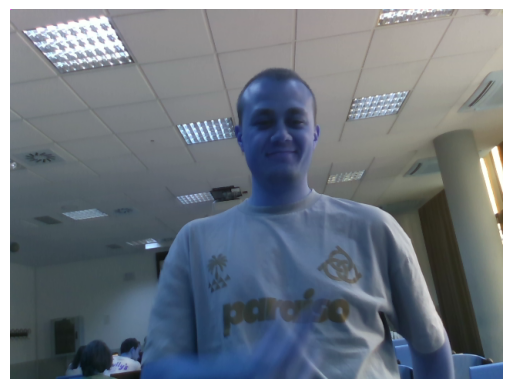

❌ Nessuna mano rilevata. Skipping frame.


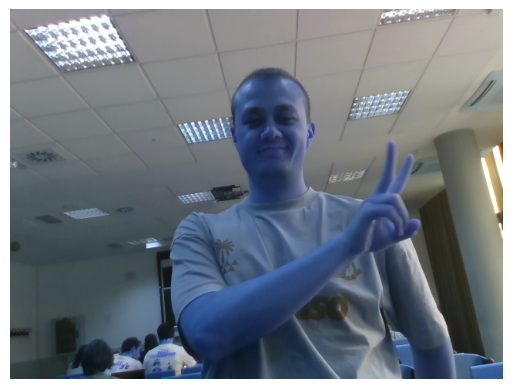

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
✅ Classe: 1 (Conf: 1.00)
Softmax: [1.0565918e-12 9.9998558e-01 1.4127583e-05 2.3071588e-07]


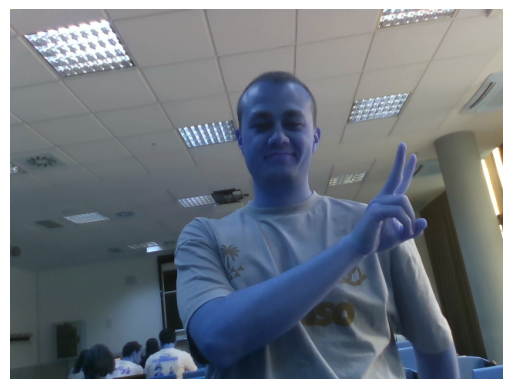

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
✅ Classe: 1 (Conf: 1.00)
Softmax: [1.6878151e-12 9.9999201e-01 7.6064593e-06 3.2507023e-07]


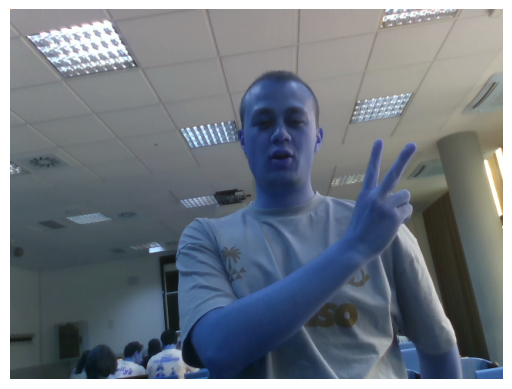

❌ Nessuna mano rilevata. Skipping frame.


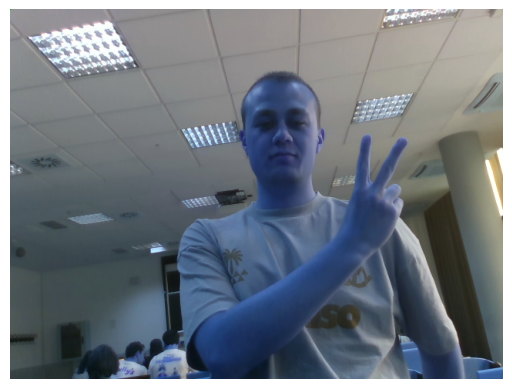

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
✅ Classe: 1 (Conf: 1.00)
Softmax: [3.5566347e-10 9.9953282e-01 4.5910152e-04 8.0971840e-06]


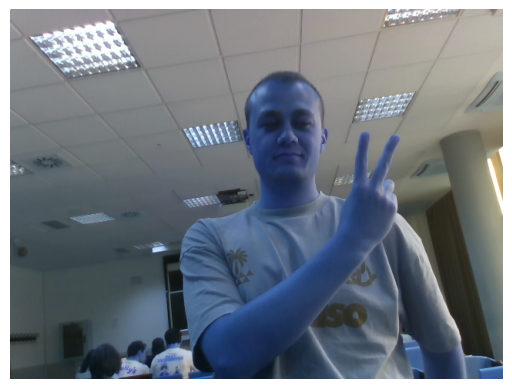

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Classe: 2 (Conf: 0.61)
Softmax: [2.7744426e-07 2.8466392e-01 6.0988319e-01 1.0545260e-01]


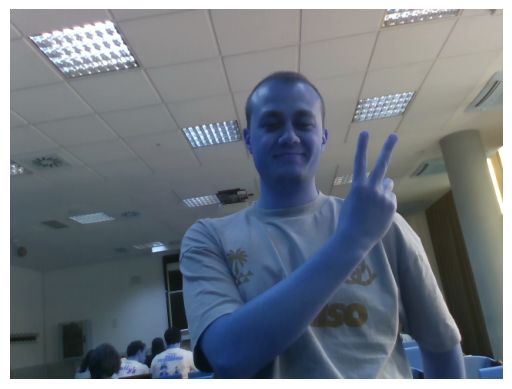

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
✅ Classe: 0 (Conf: 0.97)
Softmax: [9.6745211e-01 8.4141229e-17 1.2180651e-10 3.2547858e-02]


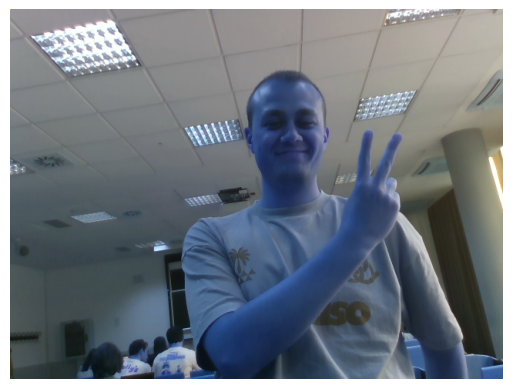

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
✅ Classe: 2 (Conf: 0.74)
Softmax: [1.4133785e-07 2.8080720e-02 7.4123442e-01 2.3068474e-01]
✅ Fine del file .bag.


In [16]:
import pyrealsense2 as rs
import numpy as np
import cv2
import mediapipe as mp
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import time

# === CONFIG ===
bag_path = "/content/20250516_171103.bag"
model_path = "best_model.h5"
depth_scale = 0.0001
radius = 40

# === Modello e scaler ===
mean = np.load("/content/scaler_mean.npy")
std = np.load("/content/scaler_scale.npy")
model = load_model(model_path)

def get_valid_depth_avg(depth_map, x, y, radius=40):
    h, w = depth_map.shape
    values = []
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)
    return np.mean(values) if values else 0.0

def get_landmark_xyz(landmarks, depth_img, h, w):
    xyz = []
    for lm in landmarks.landmark:
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        if 0 <= x_px < w and 0 <= y_px < h:
            z = get_valid_depth_avg(depth_img, x_px, y_px, radius=radius) * depth_scale
        else:
            z = 0.0
        xyz.extend([lm.x, lm.y, z])
    return np.array(xyz)

# === RealSense Pipeline ===
pipeline = rs.pipeline()
config = rs.config()
config.enable_device_from_file(bag_path, repeat_playback=False)
profile = pipeline.start(config)
align = rs.align(rs.stream.color)

# === Mediapipe ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.2)

try:
    while True:
        try:
            frames = pipeline.wait_for_frames()
        except RuntimeError:
            print("✅ Fine del file .bag.")
            break

        aligned = align.process(frames)
        depth_frame = aligned.get_depth_frame()
        color_frame = aligned.get_color_frame()

        if not depth_frame or not color_frame:
            print("⚠️ Frame non valido. Salto.")
            continue

        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        h, w, _ = color_image.shape

        rgb_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb_image)
        plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

        plt.axis('off')
        plt.show()
        if not result.multi_hand_landmarks:
            print("❌ Nessuna mano rilevata. Skipping frame.")

            continue

        first_hand_xyz = get_landmark_xyz(result.multi_hand_landmarks[0], depth_image, h, w)
        if len(result.multi_hand_landmarks) > 1:
            second_hand_xyz = get_landmark_xyz(result.multi_hand_landmarks[1], depth_image, h, w)
        else:
            second_hand_xyz = np.zeros_like(first_hand_xyz)

        input_vector = np.concatenate([first_hand_xyz, second_hand_xyz]).reshape(1, -1)
        input_vector = (input_vector - mean) / std

        prediction = model.predict(input_vector)
        predicted_class = int(np.argmax(prediction))
        confidence = np.max(prediction)

        print(f"✅ Classe: {predicted_class} (Conf: {confidence:.2f})")
        print("Softmax:", prediction[0])
        ## plot figure di image


finally:
    pipeline.stop()


# With mediapipe z

### Landmark extraction

In [24]:
import os
import cv2
import mediapipe as mp
import numpy as np
import csv

# --- Parametri ---
BASE_DIR = "/content/dataset_hands/dataset-hands"
OUTPUT_DIR = "/content/dataset_NOT_augmented"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Setup MediaPipe ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)

# Header CSV
header = [f'{dim}{i}_R' for i in range(21) for dim in ['x', 'y', 'z']]
header += [f'{dim}{i}_L' for i in range(21) for dim in ['x', 'y', 'z']]

# --- Elabora tutte le cartelle ---
for folder_name in sorted(os.listdir(BASE_DIR)):
    folder_path = os.path.join(BASE_DIR, folder_name)
    if not os.path.isdir(folder_path):
        continue

    output_csv = os.path.join(OUTPUT_DIR, f"{folder_name}.csv")
    output_npy = os.path.join(OUTPUT_DIR, f"{folder_name}.npy")
    all_landmarks = []
    count_right = count_left = count_total = 0

    with open(output_csv, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(header)

        for filename in sorted(os.listdir(folder_path)):
            if not filename.endswith("_Color.png"):
                continue

            image_path = os.path.join(folder_path, filename)
            image_bgr = cv2.imread(image_path)

            if image_bgr is None:
                print(f"❌ Errore file in: {filename} nella cartella {folder_name}")
                continue

            height, width, _ = image_bgr.shape

            for flip in [False, True]:
                img_proc = cv2.flip(image_bgr, 1) if flip else image_bgr
                img_rgb = cv2.cvtColor(img_proc, cv2.COLOR_BGR2RGB)
                results = hands.process(img_rgb)

                right_hand = [0.0] * (21 * 3)
                left_hand = [0.0] * (21 * 3)

                if results.multi_hand_landmarks and results.multi_handedness:
                    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                        label = handedness.classification[0].label
                        label = "Left" if label == "Right" else "Right"

                        landmarks = []
                        for lm in hand_landmarks.landmark:
                            x = lm.x
                            y = lm.y
                            z = lm.z
                            landmarks.extend([x, y, z])

                        if label == "Right":
                            right_hand = landmarks
                            count_right += 1
                        else:
                            left_hand = landmarks
                            count_left += 1

                combined = right_hand + left_hand
                all_landmarks.append(combined)
                csv_writer.writerow(combined)
                count_total += 1

    # Salva file .npy
    np.save(output_npy, np.array(all_landmarks))

    # Riepilogo
    print(f"\n📁 Cartella: {folder_name}")
    print(f"✅ Landmark salvati in {output_csv} e {output_npy}")
    print(f"📸 Immagini analizzate (incl. flip): {count_total}")
    print(f"🖐️ Mani rilevate: Destra {count_right} | Sinistra {count_left}")
    print(f"📊 Campioni totali: {len(all_landmarks)}")



📁 Cartella: 0
✅ Landmark salvati in /content/dataset_NOT_augmented/0.csv e /content/dataset_NOT_augmented/0.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 142 | Sinistra 138
📊 Campioni totali: 140

📁 Cartella: 1
✅ Landmark salvati in /content/dataset_NOT_augmented/1.csv e /content/dataset_NOT_augmented/1.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 67 | Sinistra 67
📊 Campioni totali: 140

📁 Cartella: 2
✅ Landmark salvati in /content/dataset_NOT_augmented/2.csv e /content/dataset_NOT_augmented/2.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 64 | Sinistra 67
📊 Campioni totali: 140

📁 Cartella: 3
✅ Landmark salvati in /content/dataset_NOT_augmented/3.csv e /content/dataset_NOT_augmented/3.npy
📸 Immagini analizzate (incl. flip): 140
🖐️ Mani rilevate: Destra 69 | Sinistra 70
📊 Campioni totali: 140


### Augmentations

In [25]:
import os
import numpy as np

# === Funzioni di Data Augmentation ===
def zoom_landmarks(landmarks, scale=0.8):
    center = landmarks[0]
    return (landmarks - center) * scale + center

def rotate_landmarks(landmarks, angle_deg=15):
    angle_rad = np.radians(angle_deg)
    center = landmarks[0]
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    rotated = np.dot(landmarks[:, :2] - center[:2], rotation_matrix) + center[:2]
    landmarks[:, :2] = rotated
    return landmarks

def translate_landmarks(landmarks, offset=(0.05, -0.03, 0.0)):
    return landmarks + np.array(offset)

# === Percorsi da modificare ===
input_base_dir = "/content/dataset_NOT_augmented"
output_base_dir = "/content/data_augumented"

os.makedirs(output_base_dir, exist_ok=True)

# === Elaborazione dei file ===
for file_name in sorted(os.listdir(input_base_dir)):
            augmented = [] # Initialize augmented here

            if file_name.endswith('.npy'):
                print(f"✔️ File: {file_name}")
                file_path = os.path.join(input_base_dir, file_name)
                landmarks = np.load(file_path)

                for i, landmark in enumerate(landmarks):
                  landmark = landmark.reshape((42, 3))  # (21 dx + 21 sx)
                  right = landmark[:21]
                  left = landmark[21:]


                  # Salva sempre l'originale
                  augmented.append(landmark.copy())

                  # === AUGMENTATION PARZIALE ===
                  # Zoom, rotazione, traslazione applicate solo alle mani presenti

                  # Zoom
                  zoomed = landmark.copy()
                  if not np.allclose(right, 0.0):
                      zoomed[:21] = zoom_landmarks(right.copy(), scale=0.8)
                  if not np.allclose(left, 0.0):
                      zoomed[21:] = zoom_landmarks(left.copy(), scale=0.8)
                  augmented.append(zoomed)

                  # Rotazione +15°
                  rotated_p15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_p15[:21] = rotate_landmarks(right.copy(), angle_deg=15)
                  if not np.allclose(left, 0.0):
                      rotated_p15[21:] = rotate_landmarks(left.copy(), angle_deg=15)
                  augmented.append(rotated_p15)

                  # Rotazione -15°
                  rotated_m15 = landmark.copy()
                  if not np.allclose(right, 0.0):
                      rotated_m15[:21] = rotate_landmarks(right.copy(), angle_deg=-15)
                  if not np.allclose(left, 0.0):
                      rotated_m15[21:] = rotate_landmarks(left.copy(), angle_deg=-15)
                  augmented.append(rotated_m15)

                  # Traslazione +
                  translated_p = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_p[:21] = translate_landmarks(right.copy(), offset=(0.05, -0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_p[21:] = translate_landmarks(left.copy(), offset=(0.05, -0.03, 0.0))
                  augmented.append(translated_p)

                  # Traslazione -
                  translated_m = landmark.copy()
                  if not np.allclose(right, 0.0):
                      translated_m[:21] = translate_landmarks(right.copy(), offset=(-0.05, 0.03, 0.0))
                  if not np.allclose(left, 0.0):
                      translated_m[21:] = translate_landmarks(left.copy(), offset=(-0.05, 0.03, 0.0))
                  augmented.append(translated_m)

            else:
                print(f"⚠️ File non valido: {file_name}")

            print("augumented lenght: ", len(augmented))
            new_name = f"{os.path.splitext(file_name)[0]}.npy"
            save_path = os.path.join(output_base_dir, new_name)
            np.save(save_path, augmented)
            print(f"✔️ File salvato: {save_path}")

⚠️ File non valido: 0.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/0.npy
✔️ File: 0.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/0.npy
⚠️ File non valido: 1.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/1.npy
✔️ File: 1.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/1.npy
⚠️ File non valido: 2.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/2.npy
✔️ File: 2.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/2.npy
⚠️ File non valido: 3.csv
augumented lenght:  0
✔️ File salvato: /content/data_augumented/3.npy
✔️ File: 3.npy
augumented lenght:  840
✔️ File salvato: /content/data_augumented/3.npy


In [26]:
import os
import numpy as np

# === Parametri ===
TARGET_DIR = "/content/data_augumented"

# === Scorri ogni file .npy nella cartella ===
for filename in sorted(os.listdir(TARGET_DIR)):
    if not filename.endswith(".npy"):
        continue

    file_path = os.path.join(TARGET_DIR, filename)
    print(f"\n📂 File: {filename}")

    # Carica il file
    data = np.load(file_path)
    print(f"🔢 Sample totali iniziali: {len(data)}")

    # Filtro dei sample
    filtered = []
    for i, sample in enumerate(data):
        sample = sample.reshape((42, 3))
        right = sample[:21]
        left = sample[21:]

        right_zero = np.allclose(right, 0.0)
        left_zero = np.allclose(left, 0.0)

        if right_zero and left_zero:
            print(f"🗑️  Sample {i} rimosso: TUTTO ZERO")
            continue

        filtered.append(sample)

    # Salva sovrascrivendo il file originale
    filtered = np.array(filtered)
    np.save(file_path, filtered)
    print(f"✅ Nuovo file salvato: {len(filtered)} sample scritti in '{filename}'")



📂 File: 0.npy
🔢 Sample totali iniziali: 840
✅ Nuovo file salvato: 840 sample scritti in '0.npy'

📂 File: 1.npy
🔢 Sample totali iniziali: 840
🗑️  Sample 156 rimosso: TUTTO ZERO
🗑️  Sample 157 rimosso: TUTTO ZERO
🗑️  Sample 158 rimosso: TUTTO ZERO
🗑️  Sample 159 rimosso: TUTTO ZERO
🗑️  Sample 160 rimosso: TUTTO ZERO
🗑️  Sample 161 rimosso: TUTTO ZERO
🗑️  Sample 162 rimosso: TUTTO ZERO
🗑️  Sample 163 rimosso: TUTTO ZERO
🗑️  Sample 164 rimosso: TUTTO ZERO
🗑️  Sample 165 rimosso: TUTTO ZERO
🗑️  Sample 166 rimosso: TUTTO ZERO
🗑️  Sample 167 rimosso: TUTTO ZERO
🗑️  Sample 180 rimosso: TUTTO ZERO
🗑️  Sample 181 rimosso: TUTTO ZERO
🗑️  Sample 182 rimosso: TUTTO ZERO
🗑️  Sample 183 rimosso: TUTTO ZERO
🗑️  Sample 184 rimosso: TUTTO ZERO
🗑️  Sample 185 rimosso: TUTTO ZERO
🗑️  Sample 186 rimosso: TUTTO ZERO
🗑️  Sample 187 rimosso: TUTTO ZERO
🗑️  Sample 188 rimosso: TUTTO ZERO
🗑️  Sample 189 rimosso: TUTTO ZERO
🗑️  Sample 190 rimosso: TUTTO ZERO
🗑️  Sample 191 rimosso: TUTTO ZERO
🗑️  Sample 456 rim

### Training

In [27]:
!python /content/gesture_recognition/train.py

2025-06-30 09:52:52.178432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751277172.248117   19898 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751277172.274651   19898 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-30 09:52:58.173055: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

### Test Results

✅ Modello caricato!
✅ Scaler caricato!


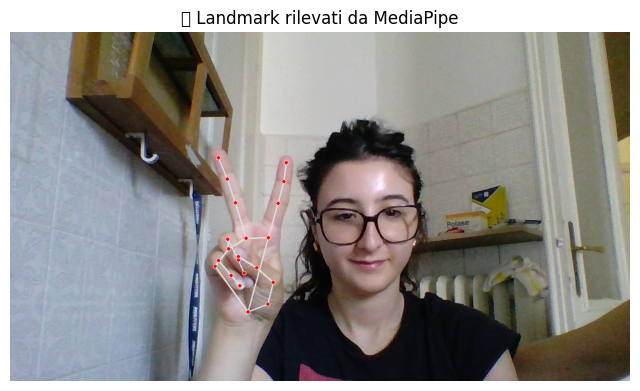

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
📈 Output del modello: [[2.7450500e-11 2.9485374e-08 9.9283433e-01 7.1657263e-03]]
🔢 Classe predetta: 2


In [32]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# === CONFIGURAZIONE ===
model_path = '/content/best_model.h5'
image_path = '/content/WIN_20250624_11_51_49_Pro.jpg'
mean_path = '/content/scaler_mean.npy'
scale_path = '/content/scaler_scale.npy'
input_size = 126  # 21 punti x 3 coordinate x 2 mani

# === CARICA MODELLO ===
model = load_model(model_path)
print("✅ Modello caricato!")

# === CARICA SCALER ===
mean = np.load(mean_path)
scale = np.load(scale_path)
print("✅ Scaler caricato!")

# === SETUP MEDIAPIPE ===
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# === CARICA IMMAGINE ===
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"❌ Immagine non trovata: {image_path}")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# === ESTRAZIONE LANDMARK ===
results = hands.process(image_rgb)

# Landmark inizializzati a zero
right_hand = [0.0] * (21 * 3)
left_hand = [0.0] * (21 * 3)
annotated_image = image_bgr.copy()

if results.multi_hand_landmarks and results.multi_handedness:
    for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
        mp_drawing.draw_landmarks(annotated_image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        label = handedness.classification[0].label
        label = "Left" if label == "Right" else "Right"

        landmarks = []
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

        if label == "Right":
            right_hand = landmarks
        elif label == "Left":
            left_hand = landmarks

# === MOSTRA IMMAGINE CON LANDMARK ===
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title("🖐️ Landmark rilevati da MediaPipe")
plt.axis("off")
plt.show()

# === COMBINA E PREPARA INPUT ===
combined = right_hand + left_hand
input_data = np.array([combined])  # shape: (1, 126)

# === NORMALIZZAZIONE ===
input_data_scaled = (input_data - mean) / scale

# === PREDIZIONE ===
prediction = model.predict(input_data_scaled)
predicted_class = np.argmax(prediction)

# === RISULTATI ===
print("📈 Output del modello:", prediction)
print("🔢 Classe predetta:", predicted_class)


### Debugging code

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

def get_valid_depth_avg(depth_map, x, y, radius=50):
    h, w = depth_map.shape
    values = []

    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            ny, nx = y + dy, x + dx
            if 0 <= ny < h and 0 <= nx < w:
                d = depth_map[ny, nx]
                if d > 0:
                    values.append(d)

    if values:
        return np.mean(values)
    else:
        return 0.0  # oppure np.nan se vuoi trattarlo diversamente
# Percorsi file
color_img_path = "/content/dataset_hands/dataset-hands/3/10_Color.png"
depth_raw_path = "/content/dataset_hands/dataset-hands/3/10_Depth.raw"

# --- Carica immagine RGB ---
image_bgr = cv2.imread(color_img_path)
if image_bgr is None:
    raise Exception("Errore nel caricamento dell'immagine a colori")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

height, width, _ = image_bgr.shape

# --- Carica depth map dal file RAW ---
depth_raw = np.fromfile(depth_raw_path, dtype=np.uint16)
depth_map = depth_raw.reshape((240, 320))  # height, width
img = cv2.imread('/content/dataset_hands/dataset-hands/3/10_Depth.png')
height, width, _ = img.shape
print(f"Width: {width}, Height: {height}")
if depth_raw.size != height * width:
    raise Exception(f"Dimensioni raw depth non corrispondono a {height}x{width}")
depth_map = depth_raw.reshape((height, width))
# Converti depth da uint16 (mm) a float32 (metri)
depth_meters = depth_map.astype(np.float32) / 10000.0

# --- Setup MediaPipe Hands ---
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

# --- Processa immagine ---
results = hands.process(image_rgb)

if not results.multi_hand_landmarks:
    print("Nessuna mano rilevata")
else:
    for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
        print(f"Mano {hand_idx+1}:")
        for i, lm in enumerate(hand_landmarks.landmark):
            # Posizione pixel landmark (x, y)
            px = min(int(lm.x * width), width - 1)
            py = min(int(lm.y * height), height - 1)

            # Profondità z da MediaPipe (normalizzata)
            z_mediapipe = lm.z

            # Profondità reale dalla depth map in metri

            z_real = get_valid_depth_avg(depth_meters, px, py)
            print(f"  Landmark {i}: (px={px}, py={py}) -> z_mediapipe={z_mediapipe:.4f}, z_real={z_real:.4f} m")

# Chiudi MediaPipe
hands.close()


Width: 320, Height: 240
Mano 1:
  Landmark 0: (px=139, py=200) -> z_mediapipe=0.0000, z_real=0.4543 m
  Landmark 1: (px=128, py=175) -> z_mediapipe=0.0401, z_real=0.4074 m
  Landmark 2: (px=123, py=152) -> z_mediapipe=0.0389, z_real=0.3819 m
  Landmark 3: (px=118, py=133) -> z_mediapipe=0.0314, z_real=0.3603 m
  Landmark 4: (px=111, py=121) -> z_mediapipe=0.0270, z_real=0.3576 m
  Landmark 5: (px=140, py=140) -> z_mediapipe=-0.0262, z_real=0.3961 m
  Landmark 6: (px=146, py=110) -> z_mediapipe=-0.0532, z_real=0.3711 m
  Landmark 7: (px=149, py=91) -> z_mediapipe=-0.0662, z_real=0.3892 m
  Landmark 8: (px=152, py=77) -> z_mediapipe=-0.0742, z_real=0.4169 m
  Landmark 9: (px=152, py=146) -> z_mediapipe=-0.0482, z_real=0.4412 m
  Landmark 10: (px=168, py=113) -> z_mediapipe=-0.0939, z_real=0.4505 m
  Landmark 11: (px=178, py=93) -> z_mediapipe=-0.1119, z_real=0.4523 m
  Landmark 12: (px=185, py=80) -> z_mediapipe=-0.1202, z_real=0.4751 m
  Landmark 13: (px=164, py=155) -> z_mediapipe=-0.0

In [18]:
import shutil
from google.colab import files


# Crea un file ZIP chiamato data_augumented.zip a partire dalla cartella
shutil.make_archive("/content/dataset_NOT_augmented", 'zip', "/content/dataset_NOT_augmented")

# Scarica il file ZIP sul tuo computer
files.download("/content/dataset_NOT_augmented.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

# === Caricamento ===
data = np.load("/content/data_augumented/2.npy")  # Assicurati che il file sia nel path corrente
print(f"🔢 Numero totale di sample: {len(data)}")

s=0
d=0
t=0
# === Analisi ===
for i, sample in enumerate(data):
    sample = sample.reshape((42, 3))  # 21 destra + 21 sinistra
    right = sample[:21]
    left = sample[21:]
    #print(f"Sample {i}: RIGHT: {right}, LEFT: {left}")

    right_zero = np.allclose(right, 0.0)
    left_zero = np.allclose(left, 0.0)

    if right_zero and not left_zero:
        s=s+1
        print(f"\n🖐️ Sample {i}: SOLO MANO SINISTRA")
    elif not right_zero and left_zero:
        d=d+1
        print(f"\n👉 Sample {i}: SOLO MANO DESTRA")
    elif not right_zero and not left_zero:
        t=t+1
        print(f"\n🤲 Sample {i}: DUE MANI")
    else:
        print(f"\n⚠️ Sample {i}: TUTTO ZERO (forse errore)")

print("mani sinistre", s)
print("mani destra", d)
print("due mani", t)

In [22]:
rm -rf /content/dataset_NOT_augmented